# Population Segmentation with SageMaker

In this notebook, you'll employ two, unsupervised learning algorithms to do **population segmentation**. Population segmentation aims to find natural groupings in population data that reveal some feature-level similarities between different regions in the US.

Using **principal component analysis** (PCA) you will reduce the dimensionality of the original census data. Then, you'll use **k-means clustering** to assign each US county to a particular cluster based on where a county lies in component space. How each cluster is arranged in component space can tell you which US counties are most similar and what demographic traits define that similarity; this information is most often used to inform targeted, marketing campaigns that want to appeal to a specific group of people. This cluster information is also useful for learning more about a population by revealing patterns between regions that you otherwise may not have noticed.

### US Census Data

You'll be using data collected by the [US Census](https://en.wikipedia.org/wiki/United_States_Census), which aims to count the US population, recording demographic traits about labor, age, population, and so on, for each county in the US. The bulk of this notebook was taken from an existing SageMaker example notebook and [blog post](https://aws.amazon.com/blogs/machine-learning/analyze-us-census-data-for-population-segmentation-using-amazon-sagemaker/), and I've broken it down further into demonstrations and exercises for you to complete.

### Machine Learning Workflow

To implement population segmentation, you'll go through a number of steps:
* Data loading and exploration
* Data cleaning and pre-processing 
* Dimensionality reduction with PCA
* Feature engineering and data transformation
* Clustering transformed data with k-means
* Extracting trained model attributes and visualizing k clusters

These tasks make up a complete, machine learning workflow from data loading and cleaning to model deployment. Each exercise is designed to give you practice with part of the machine learning workflow, and to demonstrate how to use SageMaker tools, such as built-in data management with S3 and built-in algorithms.

---

First, import the relevant libraries into this SageMaker notebook. 

In [28]:
# import packages
import os
import io

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# sagemaker libraries
import mxnet as mx
import boto3
import sagemaker 
from sagemaker import PCA
from sagemaker import get_execution_role

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

sns.set()
%matplotlib inline

## Loading the Data from Amazon S3

This particular dataset is already in an Amazon S3 bucket; you can load the data by pointing to this bucket and getting a data file by name. 

> You can interact with S3 using a `boto3` client.

In [29]:
# boto3 client to get s3 data
s3_client = boto3.client('s3')
bucket_name = 'aws-ml-blog-sagemaker-census-segmentation'

Take a look at the contents of this bucket; get a list of objects that are contained within the bucket and print out the names of the objects. You should see that there is one file, 'Census_Data_for_SageMaker.csv'.

In [30]:
# get a list of objects in the bucket
obj_list = s3_client.list_objects(Bucket=bucket_name)
print(dir(obj_list))
print('\n====\n')
print(obj_list.items())

# print object(-s) in s3 bucket
files = []

# iterate over the existing files
for content in obj_list['Contents']:
    files.append(content['Key'])

files

['__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'clear', 'copy', 'fromkeys', 'get', 'items', 'keys', 'pop', 'popitem', 'setdefault', 'update', 'values']

====

dict_items([('ResponseMetadata', {'RequestId': 'GNM7CTRJ3787X64C', 'HostId': 'pakq/b7Y+ZoslJW3XgSfPMzmXtFBrNcZYJED0TgvxNNBL0xm/SXrqMCmc19K3oGKWZBt2JtGsl4=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'pakq/b7Y+ZoslJW3XgSfPMzmXtFBrNcZYJED0TgvxNNBL0xm/SXrqMCmc19K3oGKWZBt2JtGsl4=', 'x-amz-request-id': 'GNM7CTRJ3787X64C', 'date': 'Tue, 31 Aug 2021 13:04:55 GMT', 'x-amz-bucket-region': 'us-east-1', 'content-type': 'application/xml', 'transfer-encoding': 'chunked', 'server': 'AmazonS3'}, 'Re

['Census_Data_for_SageMaker.csv']

In [31]:
file_name = files[0]
file_name

'Census_Data_for_SageMaker.csv'

Retrieve the data file from the bucket with a call to `client.get_object()`.

In [32]:
# get an S3 object by passing in the bucket and file name
data_object = s3_client.get_object(Bucket=bucket_name, Key=file_name)

display(data_object)

{'ResponseMetadata': {'RequestId': '9V2MSF2HNZ161T3M',
  'HostId': 'T/5V6ysRt6giz+Ky8qvVQ2WvyOSIS+AIk485+BrBFFEXXEaoX6WOY/xh49cl1WAkinHhQOvUXAw=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'T/5V6ysRt6giz+Ky8qvVQ2WvyOSIS+AIk485+BrBFFEXXEaoX6WOY/xh49cl1WAkinHhQOvUXAw=',
   'x-amz-request-id': '9V2MSF2HNZ161T3M',
   'date': 'Tue, 31 Aug 2021 13:04:56 GMT',
   'last-modified': 'Wed, 12 Sep 2018 15:13:37 GMT',
   'etag': '"066d37f43f7762f1eb409b1660fe9763"',
   'accept-ranges': 'bytes',
   'content-type': 'text/csv',
   'server': 'AmazonS3',
   'content-length': '613237'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2018, 9, 12, 15, 13, 37, tzinfo=tzutc()),
 'ContentLength': 613237,
 'ETag': '"066d37f43f7762f1eb409b1660fe9763"',
 'ContentType': 'text/csv',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7f58dd711940>}

Therefore, these lines of code are somewhat similar:
```
AWS approach
data_object = s3_client.get_object(Bucket=bucket_name, Key=file_name)
display(data_object)

Pythonic approach
print(obj_list.items())
```

In [33]:
# information is in the "Body" of the object
data_body = data_object['Body'].read()
print(f'Dtype: {type(data_body)}')

Dtype: <class 'bytes'>


This is a `bytes` datatype, which you can read it in using [io.BytesIO(file)](https://docs.python.org/3/library/io.html#binary-i-o).

In [34]:
# read in bytes data
data_stream = io.BytesIO(data_body)

# create a DF
counties_df = pd.read_csv(data_stream, header=0, delimiter=',')
counties_df.head(3)

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6


## Exploratory Data Analysis (EDA)

Now that you've loaded in the data, it is time to clean it up, explore it, and pre-process it. Data exploration is one of the most important parts of the machine learning workflow because it allows you to notice any initial patterns in data distribution and features that may inform how you proceed with modeling and clustering the data.

### EXERCISE: Explore data & drop any incomplete rows of data

When you first explore the data, it is good to know what you are working with. How many data points and features are you starting with, and what kind of information can you get at a first glance? In this notebook, you're required to use complete data points to train a model. So, your first exercise will be to investigate the shape of this data and implement a simple, data cleaning step: dropping any incomplete rows of data.

You should be able to answer the **question**: How many data points and features are in the original, provided dataset? (And how many points are left after dropping any incomplete rows?)

In [35]:
print('Before dropping:', counties_df.shape)

clean_counties_df = counties_df.dropna()
print('After dropping: ', clean_counties_df.shape)

Before dropping: (3220, 37)
After dropping:  (3218, 37)


### EXERCISE: Create a new DataFrame, indexed by 'State-County'

Eventually, you'll want to feed these features into a machine learning model. Machine learning models need numerical data to learn from and not categorical data like strings (State, County). So, you'll reformat this data such that it is indexed by region and you'll also drop any features that are not useful for clustering.

To complete this task, perform the following steps, using your *clean* DataFrame, generated above:
1. Combine the descriptive columns, 'State' and 'County', into one, new categorical column, 'State-County'. 
2. Index the data by this unique State-County name.
3. After doing this, drop the old State and County columns and the CensusId column, which does not give us any meaningful demographic information.

After completing this task, you should have a DataFrame with 'State-County' as the index, and 34 columns of numerical data for each county. You should get a resultant DataFrame that looks like the following (truncated for display purposes):
```
                TotalPop	 Men	  Women	Hispanic	...
                
Alabama-Autauga	55221	 26745	28476	2.6         ...
Alabama-Baldwin	195121	95314	99807	4.5         ...
Alabama-Barbour	26932	 14497	12435	4.6         ...
...

```

In [36]:
clean_counties_df.index = clean_counties_df['State'] + '-' + clean_counties_df['County']
clean_counties_df.head(3)

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
Alabama-Baldwin,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
Alabama-Barbour,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6


In [37]:
# drop state and county columns
clean_counties_df.drop(columns=['State', 'County', 'CensusId'], axis=1, inplace=True)
clean_counties_df.head(3)

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,0.0,40725,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
Alabama-Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,0.0,147695,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
Alabama-Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,0.0,20714,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6


Now, what features do you have to work with?

In [38]:
# features
features_list = clean_counties_df.columns.values
features_list

array(['TotalPop', 'Men', 'Women', 'Hispanic', 'White', 'Black', 'Native',
       'Asian', 'Pacific', 'Citizen', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
       'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment'], dtype=object)

## Visualizing the Data

In general, you can see that features come in a variety of ranges, mostly percentages from 0-100, and counts that are integer values in a large range. Let's visualize the data in some of our feature columns and see what the distribution, over all counties, looks like.

The below cell displays **histograms**, which show the distribution of data points over discrete feature ranges. The x-axis represents the different bins; each bin is defined by a specific range of values that a feature can take, say between the values 0-5 and 5-10, and so on. The y-axis is the frequency of occurrence or the number of county data points that fall into each bin. I find it helpful to use the y-axis values for relative comparisons between different features.

Below, I'm plotting a histogram comparing methods of commuting to work over all of the counties. I just copied these feature names from the list of column names, printed above. I also know that all of these features are represented as percentages (%) in the original data, so the x-axes of these plots will be comparable.

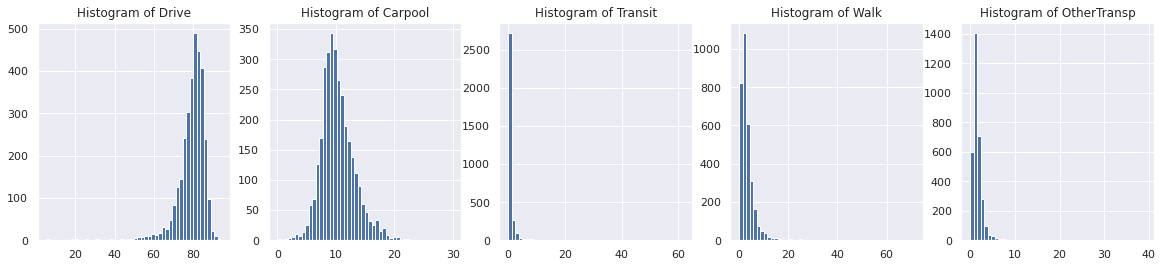

In [39]:
# commute (to work)
transport_list = ['Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp']
n_bins = 50

fig, ax = plt.subplots(1, 5, figsize=(20, 4))

for idx, col in enumerate(transport_list):
    ax[idx].hist(clean_counties_df[col], bins=n_bins)
    title = f'Histogram of {col}'
    ax[idx].set_title(title, fontsize=12)
plt.show()

### EXERCISE: Create histograms of your own

Commute transportation method is just one category of features. If you take a look at the 34 features, you can see data on profession, race, income, and more. Display a set of histograms that interest you!


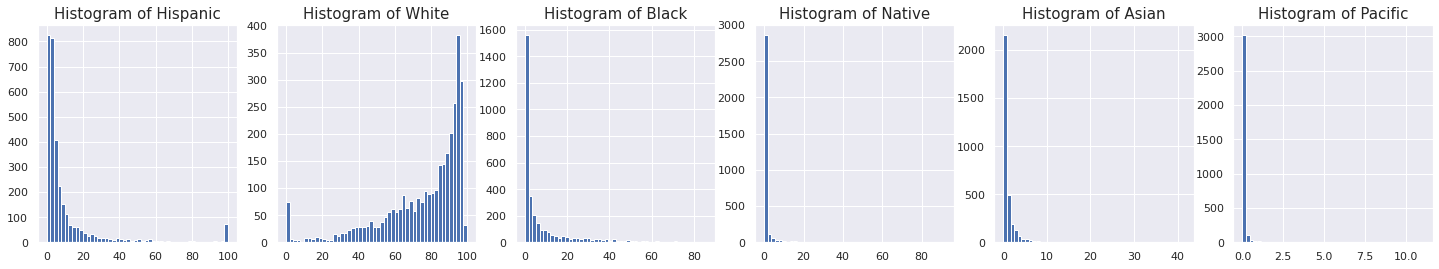

In [40]:
races = ['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific']
n_bins = 50

fig, ax = plt.subplots(1, 6, figsize=(25, 4))

for idx, col in enumerate(races):
    ax[idx].hist(clean_counties_df[col], bins=n_bins)
    title = f'Histogram of {col}'
    ax[idx].set_title(title, fontsize=15)
plt.show()

### EXERCISE: Normalize the data

You need to standardize the scale of the numerical columns in order to consistently compare the values of different features. You can use a [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) to transform the numerical values so that they all fall between 0 and 1.

In [41]:
# scale numerical features into a normalized range, 0-1
# store them in this dataframe

scaler = MinMaxScaler()
counties_scaled = scaler.fit_transform(clean_counties_df.astype(float))
counties_scaled = pd.DataFrame(counties_scaled, columns=clean_counties_df.columns, index=clean_counties_df.index)

In [42]:
counties_scaled.head(3)

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,0.005475,0.005381,0.005566,0.026026,0.759519,0.215367,0.004343,0.024038,0.0,0.006702,...,0.007022,0.033248,0.048387,0.552430,0.005139,0.750000,0.250000,0.150273,0.000000,0.208219
Alabama-Baldwin,0.019411,0.019246,0.019572,0.045045,0.832665,0.110594,0.006515,0.016827,0.0,0.024393,...,0.014045,0.035806,0.104839,0.549872,0.018507,0.884354,0.107616,0.158470,0.040816,0.205479
Alabama-Barbour,0.002656,0.002904,0.002416,0.046046,0.462926,0.543655,0.002172,0.009615,0.0,0.003393,...,0.025281,0.038363,0.043011,0.491049,0.001819,0.719388,0.248344,0.199454,0.010204,0.482192


In [43]:
counties_scaled.describe()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
count,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,...,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000
mean,0.009883,0.009866,0.009899,0.110170,0.756024,0.100942,0.018682,0.029405,0.006470,0.011540,...,0.046496,0.041154,0.124428,0.470140,0.009806,0.760810,0.194426,0.216744,0.029417,0.221775
std,0.031818,0.031692,0.031948,0.192617,0.229682,0.166262,0.078748,0.062744,0.035446,0.033933,...,0.051956,0.042321,0.085301,0.143135,0.032305,0.132949,0.106923,0.106947,0.046451,0.112138
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001092,0.001117,0.001069,0.019019,0.642285,0.005821,0.001086,0.004808,0.000000,0.001371,...,0.019663,0.023018,0.072581,0.373402,0.000948,0.697279,0.120861,0.147541,0.010204,0.150685
50%,0.002571,0.002591,0.002539,0.039039,0.842685,0.022119,0.003257,0.012019,0.000000,0.003219,...,0.033708,0.033248,0.104839,0.462916,0.002234,0.785714,0.172185,0.188525,0.020408,0.208219
75%,0.006594,0.006645,0.006556,0.098098,0.933868,0.111758,0.006515,0.028846,0.000000,0.008237,...,0.056180,0.048593,0.150538,0.560102,0.006144,0.853741,0.243377,0.256831,0.030612,0.271233
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


---
# Data Modeling


Now, the data is ready to be fed into a machine learning model!

Each data point has 34 features, which means the data is 34-dimensional. Clustering algorithms rely on finding clusters in n-dimensional feature space. For higher dimensions, an algorithm like k-means has a difficult time figuring out which features are most important, and the result is, often, noisier clusters.

Some dimensions are not as important as others. For example, if every county in our dataset has the same rate of unemployment, then that particular feature doesn’t give us any distinguishing information; it will not help t separate counties into different groups because its value doesn’t *vary* between counties.

> Instead, we really want to find the features that help to separate and group data. We want to find features that cause the **most variance** in the dataset!

So, before I cluster this data, I’ll want to take a dimensionality reduction step. My aim will be to form a smaller set of features that will better help to separate our data. The technique I’ll use is called PCA or **principal component analysis**

## Dimensionality Reduction

PCA attempts to reduce the number of features within a dataset while retaining the “principal components”, which are defined as *weighted*, linear combinations of existing features that are designed to be linearly independent and account for the largest possible variability in the data! You can think of this method as taking many features and combining similar or redundant features together to form a new, smaller feature set.

We can reduce dimensionality with the built-in SageMaker model for PCA.

### Roles and Buckets

> To create a model, you'll first need to specify an IAM role, and to save the model attributes, you'll need to store them in an S3 bucket.

The `get_execution_role` function retrieves the IAM role you created at the time you created your notebook instance. Roles are essentially used to manage permissions and you can read more about that [in this documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html). For now, know that we have a FullAccess notebook, which allowed us to access and download the census data stored in S3.

You must specify a bucket name for an S3 bucket in your account where you want SageMaker model parameters to be stored. Note that the bucket must be in the same region as this notebook. You can get a default S3 bucket, which automatically creates a bucket for you and in your region, by storing the current SageMaker session and calling `session.default_bucket()`.

In [44]:
session = sagemaker.Session()   # store the current SageMaker session 
role = get_execution_role()     # get IAM role
role

'arn:aws:iam::599739004786:role/service-role/AmazonSageMaker-ExecutionRole-20210831T133060'

In [45]:
# get default bucket
bucket_name = session.default_bucket()
bucket_name

'sagemaker-us-east-1-599739004786'

## Define a PCA Model

To create a PCA model, I'll use the built-in SageMaker resource. A SageMaker estimator requires a number of parameters to be specified; these define the type of training instance to use and the model hyperparameters. A PCA model requires the following constructor arguments:

* role: The IAM role, which was specified, above.
* train_instance_count: The number of training instances (typically, 1).
* train_instance_type: The type of SageMaker instance for training.
* num_components: An integer that defines the number of PCA components to produce.
* sagemaker_session: The session used to train on SageMaker.

Documentation on the PCA model can be found [here](http://sagemaker.readthedocs.io/en/latest/pca.html).

Below, I first specify where to save the model training data, the `output_path`.

In [46]:
# define location to store model artifacts
prefix = 'counties'
output_path = 's3://{}/{}/'.format(bucket_name, prefix)
print(f'Training artifcats will be uploaded to: {output_path}')

Training artifcats will be uploaded to: s3://sagemaker-us-east-1-599739004786/counties/


In [47]:
# rule of thumb to use when first generating a PCA is to use "features - 1" components to see the actual values
# from there, use a specific number of components
N_COMPONENTS = 33

pca_SM = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',  # ml.t2.medium won't work
             output_path=output_path,
             num_components=N_COMPONENTS,
             sagemaker_session=session)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Convert data into a RecordSet format

Next, prepare the data for a built-in model by converting the DataFrame to a numpy array of float values.

The *record_set* function in the SageMaker PCA model converts a numpy array into a **RecordSet** format that is the required format for the training input data. This is a requirement for _all_ of SageMaker's built-in models. The use of this data type is one of the reasons that allows training of models within Amazon SageMaker to perform faster, especially for large datasets.

In [48]:
# convert df to np array
train_data_np = counties_scaled.values.astype('float32')

# convert to RecordSet format
formatted_train_data = pca_SM.record_set(train_data_np)
formatted_train_data

(<class 'sagemaker.amazon.amazon_estimator.RecordSet'>, {'s3_data': 's3://sagemaker-us-east-1-599739004786/sagemaker-record-sets/PCA-2021-08-31-13-05-07-434/.amazon.manifest', 'feature_dim': 34, 'num_records': 3218, 's3_data_type': 'ManifestFile', 'channel': 'train'})

## Train the model

Call the fit function on the PCA model, passing in our formatted, training data. This spins up a training instance to perform the training job.

Note that it takes the longest to launch the specified training instance; the fitting itself doesn't take much time.

In [49]:
%%time

# train the PCA mode on the formatted data
pca_SM.fit(formatted_train_data)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-08-31 13:05:12 Starting - Starting the training job...
2021-08-31 13:05:41 Starting - Launching requested ML instancesProfilerReport-1630415112: InProgress
......
2021-08-31 13:06:41 Starting - Preparing the instances for training.........
2021-08-31 13:08:10 Downloading - Downloading input data...
2021-08-31 13:08:41 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[08/31/2021 13:08:50 INFO 140146818979648] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_num_kv_servers': 'auto', '_num_gpus': 'auto'}
[08/31/2021 13:08:50 INFO 140146818979648] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {'feature_dim

## Accessing the PCA Model Attributes

After the model is trained, we can access the underlying model parameters.

### Unzip the Model Details

Now that the training job is complete, you can find the job under **Jobs** in the **Training**  subsection  in the Amazon SageMaker console. You can find the job name listed in the training jobs. Use that job name in the following code to specify which model to examine.

Model artifacts are stored in S3 as a TAR file; a compressed file in the output path we specified + 'output/model.tar.gz'. The artifacts stored here can be used to deploy a trained model.

In [50]:
# get the name of the training job, it's suggested that you copy-paste
# from the notebook or from a specific job in the AWS console

training_job_name = 'pca-2021-08-31-13-05-12-692'

# where the model is saved, by default
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

# download & unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

# unzip model as algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

counties/pca-2021-08-31-13-05-12-692/output/model.tar.gz


2304

### MXNet Array

Many of the Amazon SageMaker algorithms use MXNet for computational speed, including PCA, and so the model artifacts are stored as an array. After the model is unzipped and decompressed, we can load the array using MXNet.

You can take a look at the MXNet [documentation, here](https://aws.amazon.com/mxnet/).

In [51]:
# load the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')
pca_model_params

{'s': 
 [1.7896362e-02 3.0864021e-02 3.2130770e-02 3.5486195e-02 9.4831578e-02
  1.2699370e-01 4.0288666e-01 1.4084760e+00 1.5100485e+00 1.5957943e+00
  1.7783760e+00 2.1662524e+00 2.2966361e+00 2.3856051e+00 2.6954880e+00
  2.8067985e+00 3.0175958e+00 3.3952675e+00 3.5731301e+00 3.6966958e+00
  4.1890211e+00 4.3457499e+00 4.5410376e+00 5.0189657e+00 5.5786467e+00
  5.9809699e+00 6.3925138e+00 7.6952214e+00 7.9913125e+00 1.0180052e+01
  1.1718245e+01 1.3035975e+01 1.9592180e+01]
 <NDArray 33 @cpu(0)>,
 'v': 
 [[ 2.46869749e-03  2.56468095e-02  2.50773830e-03 ... -7.63925165e-02
    1.59879066e-02  5.04589686e-03]
  [-2.80601848e-02 -6.86634064e-01 -1.96283013e-02 ... -7.59587288e-02
    1.57304872e-02  4.95312130e-03]
  [ 3.25766727e-02  7.17300594e-01  2.40726061e-02 ... -7.68136829e-02
    1.62378680e-02  5.13597298e-03]
  ...
  [ 1.12151138e-01 -1.17030945e-02 -2.88011521e-01 ...  1.39890045e-01
   -3.09406728e-01 -6.34506866e-02]
  [ 2.99992133e-02 -3.13433539e-03 -7.63589665e-02 .

## PCA Model Attributes

Three types of model attributes are contained within the PCA model.

* **mean**: The mean that was subtracted from a component in order to center it.
* **v**: The makeup of the principal components; (same as ‘components_’ in an sklearn PCA model).
* **s**: The singular values of the components for the PCA transformation. This does not exactly give the % variance from the original feature space, but can give the % variance from the projected feature space.
    
We are only interested in v and s. 

From s, we can get an approximation of the data variance that is covered in the first `n` principal components. The approximate explained variance is given by the formula: the sum of squared s values for all top n components over the sum over squared s values for _all_ components:

\begin{equation*}
\frac{\sum_{n}^{ } s_n^2}{\sum s^2}
\end{equation*}

From v, we can learn more about the combinations of original features that make up each principal component.


In [52]:
# get selected params
s = pd.DataFrame(pca_model_params['s'].asnumpy())
v = pd.DataFrame(pca_model_params['v'].asnumpy())

## Data Variance

Our current PCA model creates 33 principal components, but when we create new dimensionality-reduced training data, we'll only select a few, top n components to use. To decide how many top components to include, it's helpful to look at how much **data variance** the components capture. For our original, high-dimensional data, 34 features captured 100% of our data variance. If we discard some of these higher dimensions, we will lower the amount of variance we can capture.

### Tradeoff: dimensionality vs. data variance

As an illustrative example, say we have original data in three dimensions. So, three dimensions capture 100% of our data variance; these dimensions cover the entire spread of our data. The below images are taken from the PhD thesis,  [“Approaches to analyse and interpret biological profile data”](https://publishup.uni-potsdam.de/opus4-ubp/frontdoor/index/index/docId/696) by Matthias Scholz, (2006, University of Potsdam, Germany).

<img src='notebook_ims/3d_original_data.png' width=35% />

Now, you may also note that most of this data seems related; it falls close to a 2D plane, and just by looking at the spread of the data, we  can visualize that the original, three dimensions have some correlation. So, we can instead choose to create two new dimensions, made up of linear combinations of the original, three dimensions. These dimensions are represented by the two axes/lines, centered in the data. 

<img src='notebook_ims/pca_2d_dim_reduction.png' width=70% />

If we project this in a new, 2D space, we can see that we still capture most of the original data variance using *just* two dimensions. There is a tradeoff between the amount of variance we can capture and the number of component-dimensions we use to represent our data.

When we select the top n components to use in a new data model, we'll typically want to include enough components to capture about 80-90% of the original data variance. In this project, we are looking at generalizing over a lot of data and we'll aim for about 80% coverage.

**Note**: The _top_ principal components, with the largest s values, are actually at the end of the s DataFrame. Let's print out the s values for the top n, principal components.

In [58]:
# looking at top 5 components
n_principal_components = 5

start_idx = N_COMPONENTS - n_principal_components  # 33-n

# print a selection of s
print(s.iloc[start_idx:, :])
print('\n\nSum of the TOP-5 components:', np.sum(s.iloc[start_idx:, :].values.tolist()))

            0
28   7.991313
29  10.180052
30  11.718245
31  13.035975
32  19.592180


Sum of the TOP-5 components: 62.51776456832886


### EXERCISE: Calculate the explained variance

In creating new training data, you'll want to choose the top n principal components that account for at least 80% data variance. 

Complete a function, `explained_variance` that takes in the entire array `s` and a number of top principal components to consider. Then return the approximate, explained variance for those top n components. 

For example, to calculate the explained variance for the top 5 components, calculate s squared for *each* of the top 5 components, add those up and normalize by the sum of *all* squared s values, according to this formula:

\begin{equation*}
\frac{\sum_{5}^{ } s_n^2}{\sum s^2}
\end{equation*}

> Using this function, you should be able to answer the **question**: What is the smallest number of principal components that captures at least 80% of the total variance in the dataset?

**ANSWER**: At least 7 components

In [81]:
# Calculate the explained variance for the top n principal components
# you may assume you have access to the global var N_COMPONENTS
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    vals = s.iloc[N_COMPONENTS - n_top_components:, :].values    
    vals =  np.sum(vals**2) / np.sum(s**2).values
    return vals[0] 


components = []
for idx in range(1, 20):
    components.append(explained_variance(s, idx))
    print(f'{idx} components explains {components[idx-1]}% of variance')

1 components explains 0.32098713517189026% of variance
2 components explains 0.46309205889701843% of variance
3 components explains 0.5779199004173279% of variance
4 components explains 0.6645806431770325% of variance
5 components explains 0.7179827094078064% of variance
6 components explains 0.7675008773803711% of variance
7 components explains 0.8016724586486816% of variance
8 components explains 0.8315857648849487% of variance
9 components explains 0.8576101660728455% of variance
10 components explains 0.8786745667457581% of variance
11 components explains 0.8959184288978577% of variance
12 components explains 0.9117109179496765% of variance
13 components explains 0.9263849258422852% of variance
14 components explains 0.937812328338623% of variance
15 components explains 0.9484885931015015% of variance
16 components explains 0.9581285119056702% of variance
17 components explains 0.9657430052757263% of variance
18 components explains 0.9723308682441711% of variance
19 components expl

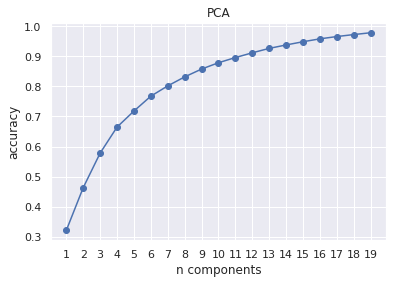

In [87]:
# visualize
plt.title('PCA')
plt.plot(range(1, 20), components, marker='o')
plt.xticks(range(1, 20))
plt.xlabel('n components')
plt.ylabel('accuracy')
plt.show()

In [88]:
# features
features_list = counties_scaled.columns.values
print('Features: \n', features_list)

Features: 
 ['TotalPop' 'Men' 'Women' 'Hispanic' 'White' 'Black' 'Native' 'Asian'
 'Pacific' 'Citizen' 'Income' 'IncomeErr' 'IncomePerCap' 'IncomePerCapErr'
 'Poverty' 'ChildPoverty' 'Professional' 'Service' 'Office' 'Construction'
 'Production' 'Drive' 'Carpool' 'Transit' 'Walk' 'OtherTransp'
 'WorkAtHome' 'MeanCommute' 'Employed' 'PrivateWork' 'PublicWork'
 'SelfEmployed' 'FamilyWork' 'Unemployment']


## Component Makeup

We can now examine the makeup of each PCA component based on **the weightings of the original features that are included in the component**. The following code shows the feature-level makeup of the first component.

Note that the components are again ordered from smallest to largest and so I am getting the correct rows by calling N_COMPONENTS-1 to get the top, 1, component.

In [104]:
def display_component(v, features_list, n, n_weights=10):
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS - n
    
    # v = The makeup of the principal components; (same as ‘components_’ in an sklearn PCA model)
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)
    
    # match weights to features in counties_scaled dataframe
    comp = pd.DataFrame(list(zip(v_1, features_list)), columns=['weights', 'features'])
    
    # sort by magnitude
    comp['abs_weight'] = comp['weights'].apply(np.abs)
    sorted_weight = comp.sort_values('abs_weight', ascending=False).head(n_weights)
    
    # display PC 
    # I've changed the original function's x from 'weights' to 'abs_weight' since it makes more sense 
    sns.barplot(data=sorted_weight, x='weights', y='features', palette='Blues_d').set_title(f'PCA {n} component makeup')
    

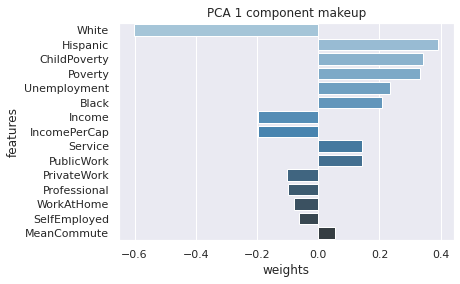

In [107]:
# display makeup of first component
num = 1
display_component(v, counties_scaled.columns.values, n=num, n_weights=15)

# Deploying the PCA Model

We can now deploy this model and use it to make "predictions". Instead of seeing what happens with some test data, we'll actually want to pass our training data into the deployed endpoint to create principal components for each data point. 

Run the cell below to deploy/host this model on an instance_type that we specify.

In [108]:
%%time
# this takes a little while, around 7mins
pca_predictor = pca_SM.deploy(initial_instance_count=1, 
                              instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-----

KeyboardInterrupt: 

We can pass the original, numpy dataset to the model and transform the data using the model we created. Then we can take the largest n components to reduce the dimensionality of our data.

In [109]:
# pass np train data to the PCA model
train_pca = pca_predictor.predict(train_data_np)

NameError: name 'pca_predictor' is not defined

In [ ]:
# check out the first itme in the produced training features
data_idx = 0
print(train_pca[data_idx])

### EXERCISE: Create a transformed DataFrame

For each of our data points, get the top n component values from the list of component data points, returned by our predictor above, and put those into a new DataFrame.

You should end up with a DataFrame that looks something like the following:
```
                     c_1	     c_2	       c_3	       c_4	      c_5	   ...
Alabama-Autauga	-0.060274	0.160527	-0.088356	 0.120480	-0.010824	...
Alabama-Baldwin	-0.149684	0.185969	-0.145743	-0.023092	-0.068677	...
Alabama-Barbour	0.506202	 0.296662	 0.146258	 0.297829	0.093111	...
...
```